# <center>Freesound General-Purpose Audio Tagging Challenge</center>

![Logo](https://upload.wikimedia.org/wikipedia/commons/3/3c/Freesound_project_website_logo.png)

Freesound is a collaborative database of Creative Commons Licensed sounds. The aim of this competition is to classify audio files that cover real-world sounds from musical instruments, humans, animals, machines, etc. Few of the labels are: `Trumpet`, `Squeak`, `Meow`, `Applause` and `Finger_sapping`.  One of the challenges is that not all labels are manually verified. A creative solution should be able to partially rely on these *weak* annotations.

Let's take a tour of the data visualization and model building through this kernel. If you like this work, please show your support by upvotes. Happy Kaggling!

### Contents
1. [Exploratory Data Analysis](#eda)
    * [Loading data](#loading_data)
    * [Distribution of Categories](#distribution)
    * [Reading Audio Files](#audio_files)
    * [Audio Length](#audio_length)
2. [Building a Model using Raw Wave](#1d_model_building)
    * [Model Discription](#1d_discription)
    * [Configuration](#configuration)
    * [DataGenerator class](#data_generator)
    * [Normalization](#1d_normalization)
    * [Training 1D Conv](#1d_training)
    * [Ensembling 1D Conv Predictions](#1d_ensembling)
3. [Introduction to MFCC](#intro_mfcc)
    * [Generating MFCC using Librosa](#librosa_mfcc)
4. [Building a Model using MFCC](#2d_model_building)
    * [Preparing Data](#2d_data)
    * [Normalization](#2d_normalization)
    * [Training 2D Conv on MFCC](#2d_training)
    * [Ensembling 2D Conv Predictions](#2d_ensembling)
5. [Ensembling 1D Conv and 2D Conv Predictions](#1d_2d_ensembling)
6. [Results and Conclusion](#conclusion)


<a id="eda"></a>
## <center>1. Exploratory Data Analysis</center>

In [1]:
# Change this to True to replicate the result
COMPLETE_RUN = True

<a id="loading_data"></a>
### Loading data

In [2]:
import numpy as np
np.random.seed(1001)

import os
import shutil

#import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

import tensorflow as tf
print('tf:',tf.__version__)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
os.getpid()

import keras
print(keras.__version__)

/home/tsai/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tf: 1.8.0
2.1.6


Using TensorFlow backend.


In [3]:
train = pd.read_csv("../input/train.csv")
#train = pd.read_csv("../input/freesound-audio-tagging/semi_train.csv")
test = pd.read_csv("../input/sample_submission.csv")

In [4]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [5]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 9473   Number of classes= 41


In [6]:
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


<a id="distribution"></a>
### Distribution of Categories

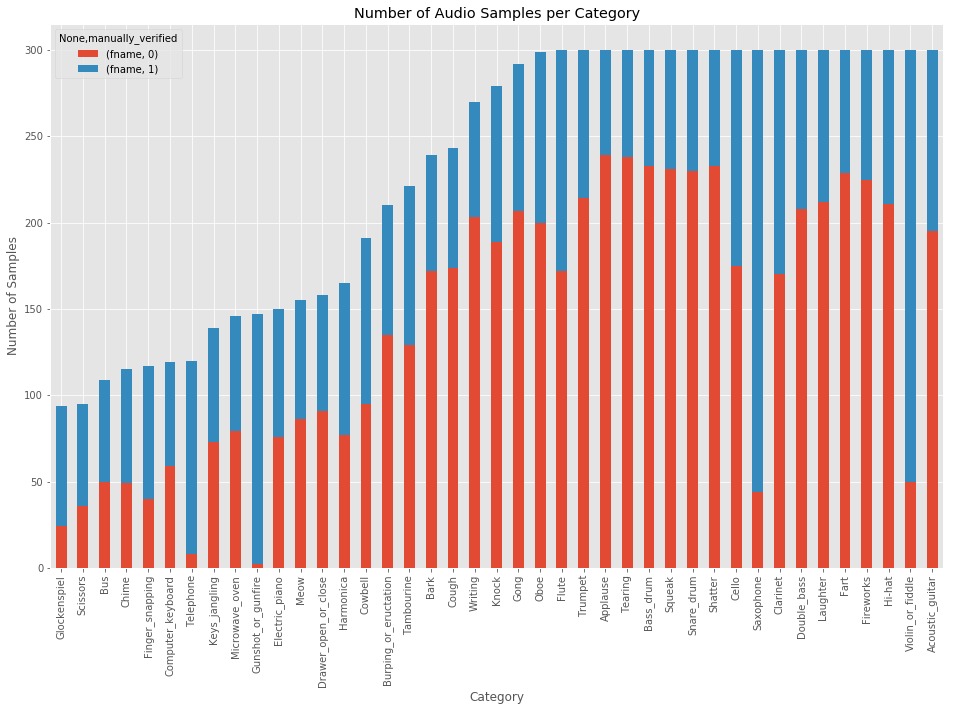

In [7]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [8]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


We observe that:
1. The number of audio samples per category is **non-nform**. The minimum number of audio samples in a category is `94` while the maximum is `300`
2. Also, the proportion of `maually_verified` labels per category is non-uniform.
<a id="audio_files"></a>
### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array

import IPython.display as ipd  # To play sound in the notebook
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'   # Hi-hat
ipd.Audio(fname)

# Using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Let's plot the audio frames

plt.plot(data, '-', );

Let's zoom in on first 1000 frames

plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

<a id="audio_length"></a>
### Audio Length

We shall now analyze the lengths of the audio files in our dataset

train['nframes'] = train['fname'].apply(lambda f: wave.open('../input/freesound-audio-tagging/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('../input/freesound-audio-tagging/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

We observe:
1. The distribution of audio length across labels is non-uniform and has high variance.

Let's now analyze the frame length distribution in Train and Test.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');

We observe:
1. Majority of the audio files are short.
1. There are four `abnormal` length in the test histogram. Let's analyze them.

abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing ", fname)
    #IPython.display.display(ipd.Audio( '../input/freesound-audio-tagging/audio_test/' + fname))

<a id="1d_model_building"></a>
## <center>2. Building a Model using Raw Wave</center>
We will build two models:
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D
2. The second model will take the MFCCs as input. (We will explain MFCC later)

<a id="1d_discription"></a>
### Keras Model using raw wave

Our model has the architecture as follows:
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important:**
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.

#### Some sssential imports

In [9]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

<a id="configuration"></a>
#### Configuration

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.

In [10]:

class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)


'\nclass Config(object):\n    def __init__(self,\n                 sampling_rate=16000, audio_duration=2, n_classes=41,\n                 use_mfcc=False, n_folds=10, learning_rate=0.0001, \n                 max_epochs=50, n_mfcc=20, datagen_num = 2):\n        self.sampling_rate = sampling_rate\n        self.audio_duration = audio_duration\n        self.n_classes = n_classes\n        self.use_mfcc = use_mfcc\n        self.n_mfcc = n_mfcc\n        self.n_folds = n_folds\n        self.learning_rate = learning_rate\n        self.max_epochs = max_epochs\n        self.datagen_num = datagen_num\n\n        self.audio_length = self.sampling_rate * self.audio_duration\n        if self.use_mfcc:\n            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)\n        else:\n            self.dim = (self.audio_length, 1)\n'

<a id="data_generator"></a>
#### DataGenerator Class

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model. 
* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch. 
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [11]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            print('X Shape:'+np.shape(X))
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1]. 

In [12]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

* The dummy model is just for debugging purpose.
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001

<a id="1d_training"></a>
#### Training 1D Conv

It is important to convert raw labels to integer indices

In [13]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.

pred_list = []
for i in range(10):
    pred_list.append(np.load(PREDICTION_FOLDER+"/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. 

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

In [14]:
import librosa
SAMPLE_RATE = 44100
fname = '../input/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [15]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 173)

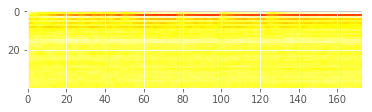

In [16]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC. 

In [17]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [18]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model
def get_big_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(64, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(64, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(64, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(64, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data

In [19]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
#config = Config(sampling_rate=44100, audio_duration=2, n_folds=5, 
#                learning_rate=0.001, use_mfcc=True, n_mfcc=40, datagen_num=3)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [21]:


verified_only = False
semi_only = False

x_train = np.load('../input/mfcc/train_mfcc.npy')
#x_pitch = np.load('../input/mfcc/train_mfcc_stretch=1.2.npy')
#x_pitch = np.load('../input/mfcc/train_mfcc_noise.npy')
#X_train = np.concatenate((x_train, x_pitch), axis = 0)
X_train = x_train

X_test = np.load('../input/mfcc/test_mfcc.npy')

y_train = np.load('../input/mfcc/label.npy')
#y_pitch = np.load('../input/mfcc/label_noise.npy')
#y = np.concatenate((y_train, y_pitch), axis = 0)
y = y_train

y_train = to_categorical(y, num_classes=config.n_classes)


<a id="2d_normalization"></a>
#### Normalization


In [22]:

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


<a id="2d_training"></a>
#### Training 2D Conv on MFCC

In [ ]:
#```python
if(verified_only):
    PREDICTION_FOLDER = "predictions_2d_conv_verified_only"
elif(semi_only):
    PREDICTION_FOLDER = "predictions_2d_conv_data_stretch=1.2"
else:
    PREDICTION_FOLDER = "predictions_2d_conv_BIG_data_noise"
    
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

#skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
skf = StratifiedKFold(n_splits=config.n_folds, shuffle = True).split(X_train, y)
for i, (train_split, val_split) in enumerate(skf):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('model/best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, batch_size=64, epochs=config.max_epochs)
    
    
    
 
   
    model.load_weights('model/best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
#```

##################################################
Fold:  0
Train on 34096 samples, validate on 3796 samples
Epoch 1/50
34096/34096 [==============================] - 34s 983us/step - loss: 2.2562 - acc: 0.3860 - val_loss: 1.9751 - val_acc: 0.4460

Epoch 00001: val_loss improved from inf to 1.97513, saving model to model/best_0.h5
Epoch 2/50
34096/34096 [==============================] - 32s 933us/step - loss: 1.5448 - acc: 0.5659 - val_loss: 1.6966 - val_acc: 0.5287

Epoch 00002: val_loss improved from 1.97513 to 1.69657, saving model to model/best_0.h5
Epoch 3/50
34096/34096 [==============================] - 32s 934us/step - loss: 1.2529 - acc: 0.6434 - val_loss: 1.5802 - val_acc: 0.5656

Epoch 00003: val_loss improved from 1.69657 to 1.58022, saving model to model/best_0.h5
Epoch 4/50
34096/34096 [==============================] - 32s 934us/step - loss: 1.0578 - acc: 0.6983 - val_loss: 1.2051 - val_acc: 0.6649

Epoch 00004: val_loss improved from 1.58022 to 1.20507, saving model to

34101/34101 [==============================] - 32s 934us/step - loss: 1.2763 - acc: 0.6382 - val_loss: 1.3641 - val_acc: 0.6159

Epoch 00003: val_loss improved from 1.51771 to 1.36408, saving model to model/best_5.h5
Epoch 4/50
34101/34101 [==============================] - 32s 929us/step - loss: 1.0872 - acc: 0.6885 - val_loss: 1.2823 - val_acc: 0.6468

Epoch 00004: val_loss improved from 1.36408 to 1.28234, saving model to model/best_5.h5
Epoch 5/50
34101/34101 [==============================] - 32s 937us/step - loss: 0.9303 - acc: 0.7357 - val_loss: 1.2223 - val_acc: 0.6526

Epoch 00005: val_loss improved from 1.28234 to 1.22232, saving model to model/best_5.h5
Epoch 6/50
34101/34101 [==============================] - 32s 935us/step - loss: 0.8074 - acc: 0.7662 - val_loss: 1.2253 - val_acc: 0.6595

Epoch 00006: val_loss did not improve from 1.22232
Epoch 7/50
34101/34101 [==============================] - 32s 927us/step - loss: 0.6931 - acc: 0.7992 - val_loss: 1.0251 - val_acc: 0.71

<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions

In [ ]:
pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i))
    #print(pred_list[i])
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv(PREDICTION_FOLDER + "/2d_conv_ensembled_submission.csv", index=False)

#### nonVerified data

<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_2d_ensembled_submission.csv", index=False)

<a id="conclusion"></a>
## <center>Results and Conclusion</center>

So far, we have trained two models. Let's analyze their relative complexity and strength.



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**

## Coming Soon

1. Data Augmentation
2. Training on Manually Verified Labels